# Esercitazione 3

In [78]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.optimize as opt

Calcolo del European call-option price e put-option price al tempo $t=0$ attraverso metodo Monte-Carlo, per poi confrontarlo col valore teorico ottenuto dalla teoria di Black-Sholes secondo la quale l'asset price evolve in modo stocastico seguendo un moto geometrico Brawniano $GBM(r,\sigma^2)$ con tasso di interesse a rischio nullo $r$ e volatilità $\sigma$ . 

Dato il prezzo di consegna $K$ (fissato inizialmente) e dato il prezzo di mercato $S(t)$, si hanno:
- Call-option price al tempo $t$: 
$$C[S(t),t]=max[0,S(t)-K]$$
- Put-option price al tempo $t$:    $$P[S(t),t]=max[0,K-S(t)]$$

Noti i prezzi di Call e di Put al tempo $t=T$ è possibile ottenere i prezzi al tempo $t=0$ moltiplicando per il l'inverso dell'interesse garantito da una banca con un deposito al tempo $t_0=0$
- Call-option price al tempo $t_0=0$: 
$$C[S(0),0]=e^{-rT}max[0,S(T)-K]$$
- Put-option price al tempo $t_0=0$:    
$$P[S(0),0]=e^{-rT}max[0,K-S(T)]$$

Se assumiamo $S(t) \sim GBM(r,\sigma)$ con valore iniziale $S(0)$ si ha
    $$S(t) = S(0) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W(t)\right]$$
 dove $W(t)\sim\mathcal{N}(0,t)$, che chiameremo calcolo "diretto". Inoltre, dato che gli incrementi $W$ sono indipendenti e distribuiti normalmente, possiamo ottenere l'asset price con un metodo ricorsivo campionando valori discreti di $S\sim GBM(\mu,\sigma^2)$ per diversi tempi $t_1 < t_2 < … < t_n$:
$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)
    +\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$
    con $Z_i \sim \mathcal{N}(0,1)$, che chiameremo metodo "discreto"
    

### Balck-Scholes soluzione analitica


La soluzione analitica di Black-Scholes  per un prezzo al tempo t<T:
- European Call-option price:
$$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$
- European Put-option price:
$$ P\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$

dove 
$$d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2} (T-t) \right)\right]$$

dove $d_2 = d_1 - \sigma\sqrt{T-t}$, e dove
$$ N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$
è la cumulata di una Gaussiana $\sim \mathcal{N}(\mu=0,\sigma^2=1)$,
e dove
$${\rm erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} dz \, e^{-z^2}$$

I parametri usati sono i seguenti:
- prezzo di mercato $t=0$: $S(0)=100$
- tempo di consegna: $T=1$
- prezzo di consegna: $K=100$
- tasso di interesse a rischio nullo: $r=0.1$
- volatilità: $\sigma=0.25$

In [111]:
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt

# data
S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / np.sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * np.sqrt(T)
    C = S0 * N(d1) - K * np.exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * np.exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    call, put = black_scholes(S0, K, T, r, sigma)
    print(" == BLACK-SCHOLES ==")
    print("call: ", call)
    print("put: ", put)

 == BLACK-SCHOLES ==
call:  14.975790778311286
put:  5.4595325819072364


Per calcolare il call price e put price utilizzo la statistica a blocchi con parametri
- Numero di dati campionati N_throws= 70000
- Numero di blocchi N_blocks=100

## European Call price 

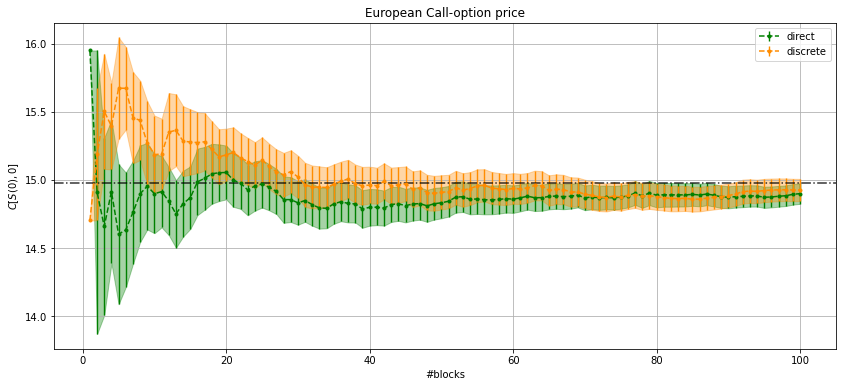

In [193]:
file1=open('Eur_call_direct.csv')
file2=open('Eur_call_discrete.csv')

x_ECD, ECD, err_ECD=np.loadtxt(file1, delimiter=",", usecols=[0,1,2], unpack=True)
x_ECd, ECd, err_ECd=np.loadtxt(file2, delimiter=",", usecols=[0,1,2], unpack=True)

N_blocks=100

plt.figure(figsize=(14,6))
plt.errorbar(x_ECD/(np.max(x_ECD)/N_blocks),ECD,yerr=err_ECD,color='green',fmt='.--',elinewidth=1.4,label='direct')
plt.errorbar(x_ECd/(np.max(x_ECd)/N_blocks),ECd,yerr=err_ECd,color='darkorange',fmt='.--',elinewidth=1.4,label='discrete')

plt.fill_between(x_ECD/(np.max(x_ECD)/N_blocks),ECD-err_ECD,ECD+err_ECD,alpha=0.35,color='green')
plt.fill_between(x_ECd/(np.max(x_ECd)/N_blocks),ECd-err_ECd,ECd+err_ECd,alpha=0.35,color='darkorange')
plt.legend()
plt.axhline(call, color="k",ls="-.", alpha=0.8, label="analitic result")
plt.xlabel('#blocks')
plt.ylabel(f'$C[S(0),0]$')
plt.title('European Call-option price')
plt.grid(True)
plt.show()

 ## European Put price

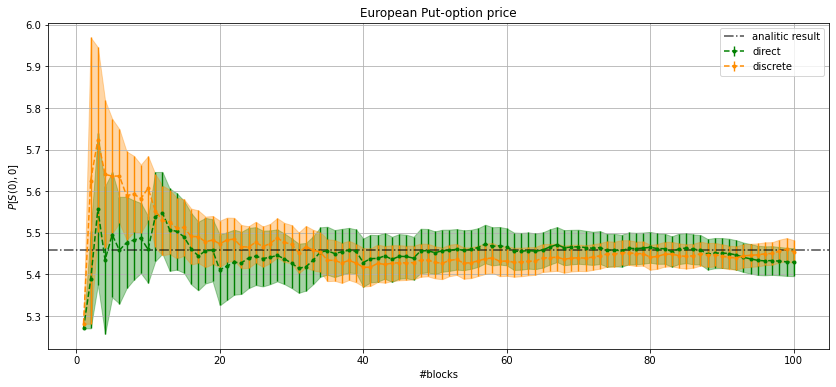

In [194]:
file1=open('Eur_put_direct.csv')
file2=open('Eur_put_discrete.csv')

x_EPD, EPD, err_EPD=np.loadtxt(file1, delimiter=",", usecols=[0,1,2], unpack=True)
x_EPd, EPd, err_EPd=np.loadtxt(file2, delimiter=",", usecols=[0,1,2], unpack=True)

N_blocks=100

plt.figure(figsize=(14,6))
plt.errorbar(x_EPD/(np.max(x_EPD)/N_blocks),EPD,yerr=err_EPD,color='green',fmt='.--',elinewidth=1.4,label='direct')
plt.errorbar(x_EPd/(np.max(x_EPd)/N_blocks),EPd,yerr=err_EPd,color='darkorange',fmt='.--',elinewidth=1.4,label='discrete')

plt.fill_between(x_EPD/(np.max(x_EPD)/N_blocks),EPD-err_EPD,EPD+err_EPD,alpha=0.35,color='green')
plt.fill_between(x_EPd/(np.max(x_EPd)/N_blocks),EPd-err_EPd,EPd+err_EPd,alpha=0.35,color='darkorange')
plt.xlabel('#blocks')
plt.axhline(put, color="k",ls='-.', alpha=0.7, label="analitic result")
plt.ylabel(f'$P[S(0),0]$')
plt.legend()
plt.title('European Put-option price')
plt.grid(True)
plt.show()

I risultati sono in accordo con il risultato analitico